In [1]:
##Libraries to Import
import numpy as np
import os
import cv2
import time
import random
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tkinter import filedialog
import tkinter as tk
%matplotlib inline

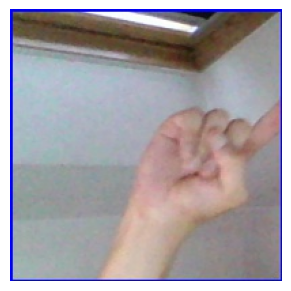

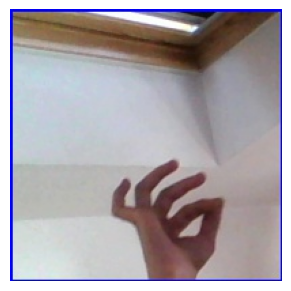

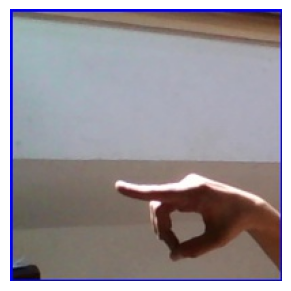

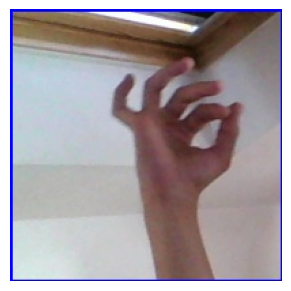

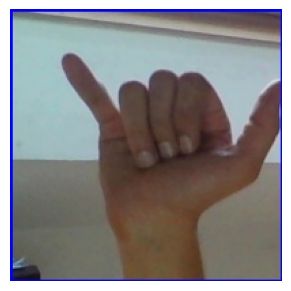

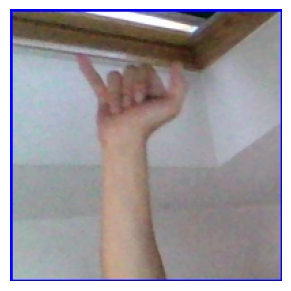

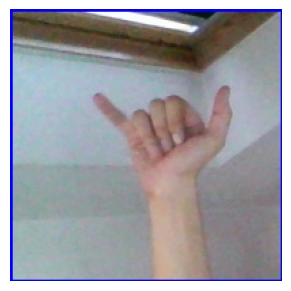

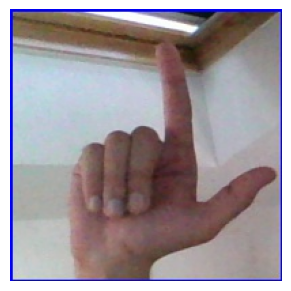

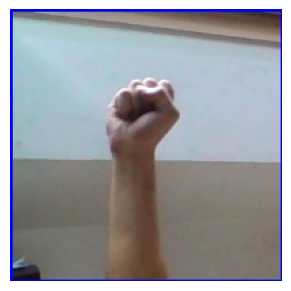

In [11]:
# Path to the dataset directory
images = glob("asl_dataset_train/asl_dataset_train/**/**")

# Filter to include only common image formats (e.g., jpg, jpeg, png)
valid_image_extensions = ['jpg', 'jpeg', 'png']
images = [img for img in images if img.split('.')[-1].lower() in valid_image_extensions]

# Visualizing some random images from the dataset
for i in range(9):
    image_path = random.choice(images)
    
    # Check if the image path is valid and the image is loaded
    image = cv2.imread(image_path)
    
    if image is not None:
        # Convert BGR (OpenCV format) to RGB for visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(12, 12))
        plt.subplot(331 + i)
        plt.imshow(image_rgb)
        plt.axis('off')
    else:
        print(f"Warning: Could not load image {image_path}")

plt.show()


In [48]:
## Preparing Data for Training
# Hyperparameters
img_size = 48
batch_size = 64

# Use ImageDataGenerator for both training and validation (without validation split)
train_datagen = ImageDataGenerator(rescale=1./255)  # For training data
validation_datagen = ImageDataGenerator(rescale=1./255)  # For validation data

# Training data generator
train_generator = train_datagen.flow_from_directory("asl_dataset_train/asl_dataset_train/",
                                                    target_size=(img_size, img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory("asl_dataset_validation/",
                                                              target_size=(img_size, img_size),
                                                              color_mode="grayscale",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

# Debug: Print the number of samples to verify the dataset
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {validation_generator.n}")

Found 87001 images belonging to 29 classes.
Found 17401 images belonging to 29 classes.
Training samples: 87001
Validation samples: 17401


In [50]:
#Building the Model
# Define CNN model architecture
def build_sign_language_model(input_shape):
    model = Sequential()
    
    # Convolutional Layer 1
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Convolutional Layer 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Convolutional Layer 3
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(29, activation='softmax'))  # 29 classes: 26 letters + space, delete, nothing
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Build and display the model summary
model = build_sign_language_model((img_size, img_size, 1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,483,997 (9.48 MB)

 Trainable params: 2,483,101 (9.47 MB)

 Non-trainable params: 896 (3.50 KB)

In [54]:
# Model checkpoint and learning rate reducer
checkpoint = ModelCheckpoint('asl_model_best.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)

# Training parameters
epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size  # Use validation generator

# Training the model
history = model.fit(train_generator, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    validation_data=validation_generator,  # Use validation generator
                    validation_steps=validation_steps, 
                    callbacks=[checkpoint, reduce_lr])

# Evaluating model performance on validation set
model.evaluate(validation_generator)  # Use validation generator

Epoch 1/20
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8223 - loss: 0.5372
Epoch 1: val_accuracy improved from -inf to 0.96771, saving model to asl_model_best.keras
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 259s 190ms/step - accuracy: 0.8223 - loss: 0.5371 - val_accuracy: 0.9677 - val_loss: 0.1172 - learning_rate: 5.0000e-04
Epoch 2/20
   1/1359 ━━━━━━━━━━━━━━━━━━━━ 3:04 136ms/step - accuracy: 0.9062 - loss: 0.3811
Epoch 2: val_accuracy improved from 0.96771 to 1.00000, saving model to asl_model_best.keras
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.9062 - loss: 0.3811 - val_accuracy: 1.0000 - val_loss: 2.5328e-04 - learning_rate: 5.0000e-04
Epoch 3/20


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9107 - loss: 0.2629
Epoch 3: val_accuracy did not improve from 1.00000
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 269s 197ms/step - accuracy: 0.9107 - loss: 0.2629 - val_accuracy: 0.9797 - val_loss: 0.0616 - learning_rate: 5.0000e-04
Epoch 4/20
   1/1359 ━━━━━━━━━━━━━━━━━━━━ 3:24 150ms/step - accuracy: 0.9531 - loss: 0.0988
Epoch 4: val_accuracy did not improve from 1.00000
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.9531 - loss: 0.0988 - val_accuracy: 1.0000 - val_loss: 1.6133e-04 - learning_rate: 5.0000e-04
Epoch 5/20
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9552 - loss: 0.1281
Epoch 5: val_accuracy did not improve from 1.00000
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 279s 205ms/step - accuracy: 0.9552 - loss: 0.1281 - val_accuracy: 0.9972 - val_loss: 0.0144 - learning_rate: 1.0000e-04
Epoch 6/20
   1/1359 ━━━━━━━━━━━━━━━━━━━━ 3:55 173ms/step - accuracy: 0.9844 - loss: 0.0273
Epoch 6: val_accuracy did not improve fr

[0.002979876706376672, 0.9994828104972839]

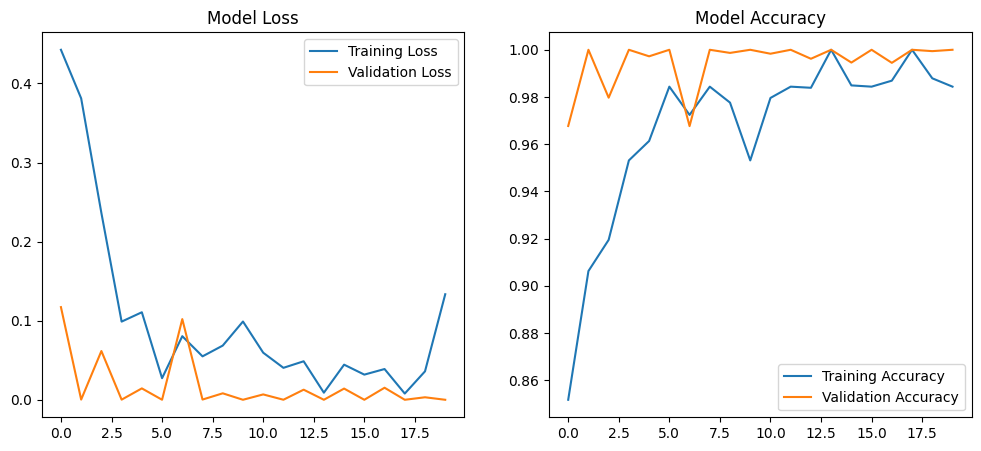

In [56]:
##Plotting Model Performance

# Plotting training history for loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.show()

In [58]:
##Time-Based Operation

def is_operational():
    current_time = time.strftime("%H:%M:%S")
    return "18:00:00" <= current_time <= "22:00:00"

def main_operation():
    if is_operational():
        print("Model is operational.")
        # Call real-time detection or image upload functions here
    else:
        print("Model not available. Please use between 6 PM and 10 PM.")


In [ ]:
##GUI for Image Upload and Real-Time Video

import tkinter as tk
from tkinter import filedialog
import cv2

def open_image():
    filepath = filedialog.askopenfilename()
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    # Handle prediction result here (map index to class label)
    print("Predicted Class:", np.argmax(prediction))

def start_video():
    cap = cv2.VideoCapture(0)
    while is_operational():
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(gray, (img_size, img_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        # Display prediction results on the video feed
        cv2.imshow('Video Feed', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# GUI Window using Tkinter
root = tk.Tk()
root.title("Sign Language Detection")
root.geometry("300x200")

upload_btn = tk.Button(root, text="Upload Image", command=open_image)
upload_btn.pack(pady=10)

video_btn = tk.Button(root, text="Start Real-Time Video", command=start_video)
video_btn.pack(pady=10)

root.mainloop()


In [62]:
# Save model architecture to JSON
model_json = model.to_json()
with open("asl_model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("asl_model_weights.weights.h5")
